In [66]:
from __future__ import division

import scipy as sp
import scipy.io
from scipy.optimize import minimize
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from bqplot import pyplot as bqp
%matplotlib inline  

# 1 K-means clustering

## 1.1 Implementing K-means 

In [31]:
data_2_dict = scipy.io.loadmat('ex7/ex7data2.mat')

In [32]:
X = data_2_dict['X']
M = len(X)

### 1.1.1 Finding closest centroids

In [33]:
K = 3
centroids = sp.array([[3, 3], [6, 2], [8, 5]])

In [34]:
def find_closest_centroids_v1(X, centroids):
    centroid_indices = []
    for example in X:
        distances = []
        for centroid in centroids:
            distances.append(sp.sqrt((example[0] - centroid[0])**2 + (example[1] - centroid[1])**2))
        centroid_indices.append(sp.array(distances).argmin())
    return sp.array(centroid_indices)

In [35]:
def find_closest_centroids_v2(X, centroids):
    distances = sp.array([sp.sqrt((X.T[0] - centroid[0])**2 + (X.T[1] - centroid[1])**2) for centroid in centroids])
    return distances.argmin(axis=0)

In [48]:
timeit find_closest_centroids_v1(X, centroids)

100 loops, best of 3: 18.3 ms per loop


In [49]:
timeit find_closest_centroids_v2(X, centroids)

10000 loops, best of 3: 96.1 µs per loop


In [36]:
find_closest_centroids = find_closest_centroids_v2

centroid_indices = find_closest_centroids(X, centroids)
print centroid_indices[:3]

[0 2 1]


### 1.1.2 Computing centroid means

In [37]:
def compute_means(X, centroid_indices, K):
    centroids = []
    for k in xrange(K):
        centroids.append(sp.mean(X[centroid_indices == k], axis=0))
    return sp.array(centroids)

In [38]:
centroids = compute_means(X, centroid_indices, K)
print centroids

[[ 2.42830111  3.15792418]
 [ 5.81350331  2.63365645]
 [ 7.11938687  3.6166844 ]]


## 1.2 K-means on example dataset

In [39]:
def run_k_means(X, K, centroids, iterations):
    centroids_history = [centroids]
    for i in xrange(iterations):
        centroid_indices = find_closest_centroids(X, centroids)
        centroids = compute_means(X, centroid_indices, K)
        centroids_history.append(centroids)
    return centroids, centroid_indices, centroids_history

In [40]:
centroids = sp.array([[3, 3], [6, 2], [8, 5]])
iterations = 10

centroids, centroid_indices, centroids_history = run_k_means(X, K, centroids, iterations)

In [41]:
def initialize_viz(fig_num, X, M, centroids_history, colors):
    iteration_number = 0

    fig = bqp.figure(fig_num, title='Iteration number ' + str(iteration_number))
    
    for k, color in enumerate(colors):    
        X_cluster = X[centroid_indices == k]
        bqp.plot(X_cluster.T[0], X_cluster.T[1], color + 'o', default_size=16, default_opacities=[0.5] * M)

    centroid_snap_T = centroids_history[0].T
    centroids_dict = {}
    for k, color in enumerate(colors):
        centroids_dict[color] = sp.array([centroid_snap_T[0][k], centroid_snap_T[1][k]])
        bqp.plot(centroids_dict[color].T[0].reshape(-1), centroids_dict[color].T[1].reshape(-1), color + '+', stroke='white', stroke_width=2.5,
                 default_size=96)

    bqp.show()
    
    return iteration_number, centroids_dict


def update_viz(fig_num, centroids_history, colors, iteration_number):
    iteration_number += 1
    if iteration_number >= iterations: iteration_number = 0

    bqp.figure(fig_num, title='Iteration number ' + str(iteration_number))
    centroid_snap_T = centroids_history[iteration_number].T
    for k, color in enumerate(colors):
        centroids_dict[color] = \
            sp.vstack((centroids_dict[color], sp.array([centroid_snap_T[0][k], centroid_snap_T[1][k]])))
        bqp.plot(centroids_dict[color].T[0], centroids_dict[color].T[1],'k-')        
        bqp.plot(centroids_dict[color].T[0], centroids_dict[color].T[1], color + '+', stroke='white', stroke_width=2.5,
                 default_size=96)
        
    return iteration_number, centroids_dict

In [42]:
colors = ['r', 'g', 'b']
fig_num = 1

iteration_number, centroids_dict = initialize_viz(fig_num, X, M, centroids_history, colors)

In [43]:
iteration_number, centroids_dict = update_viz(fig_num, centroids_history, colors, iteration_number)

## 1.3 Random initialization

In [44]:
def run_k_means_rand_init(X, K, iterations):
    rand_indices = sp.arange(len(X))
    sp.random.shuffle(rand_indices)
    centroids = X[rand_indices][:K]
    
    centroids_history = [centroids]
    for i in xrange(iterations):
        centroid_indices = find_closest_centroids(X, centroids)
        centroids = compute_means(X, centroid_indices, K)
        centroids_history.append(centroids)
    return centroids, centroid_indices, centroids_history

In [45]:
centroids, centroid_indices, centroids_history = run_k_means_rand_init(X, K, iterations)

In [46]:
fig_num = 2

iteration_number, centroids_dict = initialize_viz(fig_num, X, M, centroids_history, colors)

In [47]:
iteration_number, centroids_dict = update_viz(fig_num, centroids_history, colors, iteration_number)

## 1.4 Image compression with K-means

### 1.4.1 K-means on pixels

In [48]:
A = sp.misc.imread('ex7/bird_small.png')

In [49]:
A = A.reshape(-1, 3)

In [50]:
A = A.astype('float') / 255.

In [51]:
K = 16
iterations = 10

centroids, centroid_indices, centroids_history = run_k_means_rand_init(A, K, iterations)

In [52]:
centroid_indices = find_closest_centroids(A, centroids)

In [53]:
A_recon = centroids[centroid_indices]

In [54]:
A_recon = A_recon.reshape(-1, 128, 3)

In [55]:
sp.misc.imsave('ex7_ipynb_img/bird_small_recon.png', A_recon)

# 2 Principal component analysis

## 2.1 Example dataset

In [110]:
data_1_dict = scipy.io.loadmat('ex7/ex7data1.mat')

In [111]:
X = data_1_dict['X']
M = len(X)

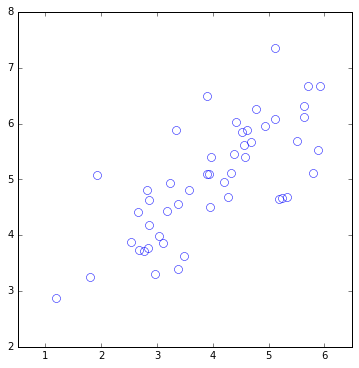

In [112]:
plt.figure(figsize=(6, 6))
plt.plot(X.T[0], X.T[1], 'bo', mfc='none', mec='b', ms=8)
plt.xlim(0.5, 6.5)
plt.ylim(2, 8)
plt.savefig('ex7_ipynb_img/fig4.jpg')
plt.show()

## 2.2 Implementing PCA

In [113]:
def feature_normalize(X):
    mu = sp.mean(X, axis=0)
    sig = sp.std(X, axis=0)
    X_norm = (X - mu) / sig
    return X_norm, mu, sig

In [114]:
def pca(X_norm):
    Sigma = 1 / M * X_norm.T.dot(X_norm)
    U, S, V = la.svd(Sigma)
    return U, S

In [115]:
X_norm, mu, sig = feature_normalize(X)
U, S = pca(X_norm)

print 'top eigenvector:', U.T[0]

top eigenvector: [-0.70710678 -0.70710678]


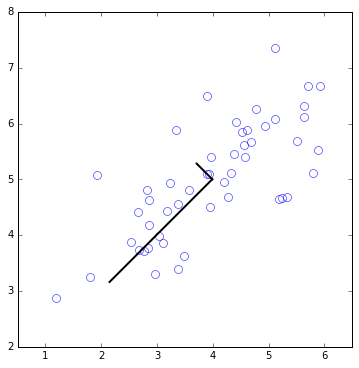

In [10]:
U_0_end_pts = sp.vstack((mu, mu + 1.5 * S[0] * U.T[0]))
U_1_end_pts = sp.vstack((mu, mu + 1.5 * S[1] * U.T[1]))

plt.figure(figsize=(6, 6))
plt.plot(X.T[0], X.T[1], 'bo', mfc='none', mec='b', ms=8)
plt.plot(U_0_end_pts.T[0], U_0_end_pts.T[1], 'k-', lw=2)
plt.plot(U_1_end_pts.T[0], U_1_end_pts.T[1], 'k-', lw=2)
plt.xlim(0.5, 6.5)
plt.ylim(2, 8)
plt.savefig('ex7_ipynb_img/fig5.jpg')
plt.show()

## 2.3 Dimensionality reduction

### 2.3.1 Projecting the data onto the principal components

In [116]:
def project_data(X, U, K):
    return X.dot(U[:, :K])

In [117]:
print project_data(X_norm, U, 1)[0]

[ 1.49631261]


### 2.3.2 Reconstructing an approximation of the data

In [118]:
def recover_data(Z, U, K):
    return Z.dot(U[:, :K].T)

In [119]:
Z = project_data(X_norm, U, 1)

In [120]:
X_rec = recover_data(Z, U, 1)

print X_rec[0]

[-1.05805279 -1.05805279]


### 2.3.3 Visualizing the projections

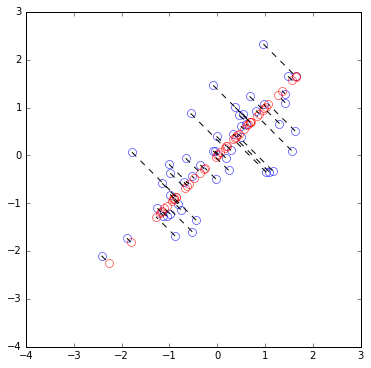

In [121]:
plt.figure(figsize=(6, 6))
plt.plot(X_norm.T[0], X_norm.T[1], 'bo', mfc='none', mec='b', ms=8)
plt.plot(X_rec.T[0], X_rec.T[1], 'ro', mfc='none', mec='r', ms=8)
for (x, y), (x_rec, y_rec) in zip(X_norm, X_rec):
    plt.plot([x, x_rec], [y, y_rec], 'k--', lw=1)
plt.xlim(-4, 3)
plt.ylim(-4, 3)
plt.savefig('ex7_ipynb_img/fig6.jpg')
plt.show()

## 2.4 Face image dataset

In [21]:
data_faces_dict = scipy.io.loadmat('ex7/ex7faces.mat')

In [22]:
X = data_faces_dict['X']
M, N = X.shape

In [23]:
def grid_plot(X, N, dim, file_name):
    
    fig = plt.figure(figsize=(6, 6))

    gs = gridspec.GridSpec(dim, dim)
    gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
              hspace=0.05, wspace=0.05)

    k = 0
    for i in xrange(dim):
        for j in xrange(dim):
            ax = plt.subplot(gs[i, j])
            ax.axis('off')
            ax.imshow(X[k].reshape(int(sp.sqrt(N)), int(sp.sqrt(N))).T,
                     cmap=plt.get_cmap('Greys'), #vmin=-1, vmax=1,
                     interpolation = 'nearest')#, alpha = 1.0)
            k += 1

    plt.savefig('ex7_ipynb_img/' + file_name, dpi=300)
    plt.show()
    
    pass

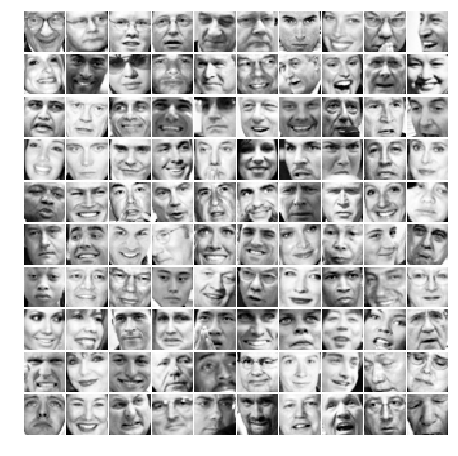

In [24]:
grid_plot(-X, N, 10, 'fig7.jpg')

### 2.4.1 PCA on faces

In [25]:
X_norm, mu, sig = feature_normalize(X)
U, S = pca(X_norm)

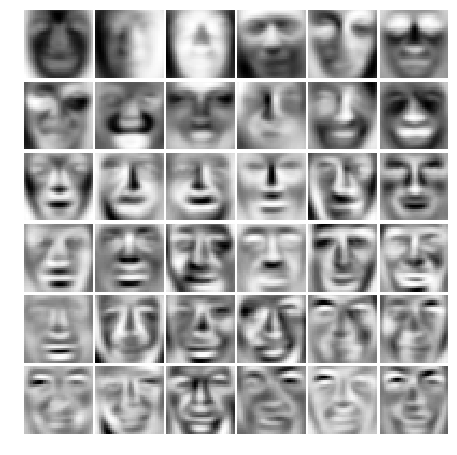

In [27]:
grid_plot(-U.T, N, 6, 'fig8.jpg')

### 2.4.2 Dimensionality reduction

In [28]:
Z = project_data(X_norm, U, 100)

In [29]:
X_rec = recover_data(Z, U, 100)

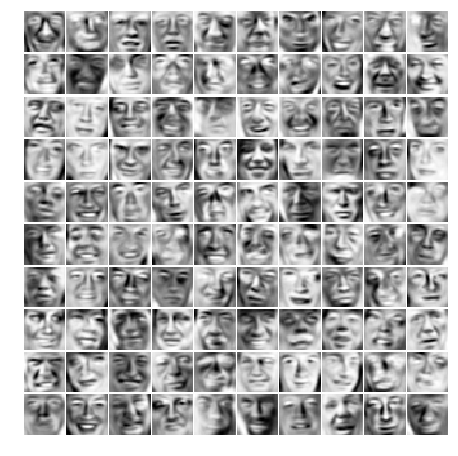

In [30]:
grid_plot(-X_rec, N, 10, 'fig9.jpg')

## 2.5 PCA for visualization

In [129]:
X = A.reshape(-1, 3)
M = len(X)

In [130]:
rand_indices = sp.arange(M)
sp.random.shuffle(rand_indices)

centroid_indices_sub = centroid_indices[rand_indices[:1000]]
X_sub = X[rand_indices[:1000]]

In [131]:
colors = plt.cm.rainbow(sp.linspace(0, 1, 16))

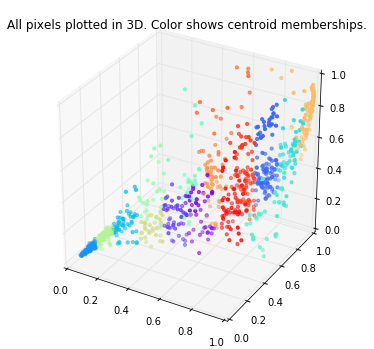

In [132]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_sub[:, 0], X_sub[:, 1], X_sub[:, 2], c=colors[centroid_indices_sub], s=10,
          edgecolor=colors[centroid_indices_sub])
ax.set_title('All pixels plotted in 3D. Color shows centroid memberships.')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
plt.savefig('ex7_ipynb_img/fig_10.jpg', dpi=300)
plt.show()

In [133]:
X_sub_norm, mu, sig = feature_normalize(X_sub)
U, S = pca(X_sub_norm)

In [134]:
U.shape

(3, 3)

In [135]:
Z = project_data(X_sub_norm, U, 2)

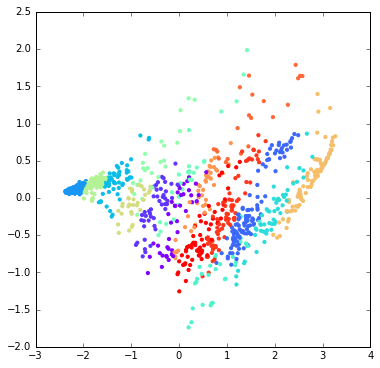

In [137]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(-Z.T[0], -Z.T[1], c=colors[centroid_indices_sub], s=10,
          edgecolor=colors[centroid_indices_sub])
plt.savefig('ex7_ipynb_img/fig_11.jpg', dpi=300)
plt.show()